#Notebook for plotting the results of our system against the baseline

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import defaultdict
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.patches as mpatches
import pandas as pd

0.005 0.5 0.2525
new best baseline 50_None 1.0 absolute [50.0, 0.5]
new best baseline 50 1.0 0.2525
0.01 0.469957081545 0.239978540772
new best baseline 100_None 1.0 absolute [100.0, 0.469957081545]
new best baseline 100 1.0 0.239978540772
0.015 0.424892703863 0.219946351931
new best baseline 150_None 1.0 absolute [150.0, 0.424892703863]
new best baseline 150 1.0 0.219946351931
0.02 0.399141630901 0.209570815451
new best baseline 200_None 1.0 absolute [200.0, 0.399141630901]
new best baseline 200 1.0 0.209570815451
0.025 0.37339055794 0.19919527897
new best baseline 250_None 1.0 absolute [250.0, 0.37339055794]
new best baseline 250 1.0 0.19919527897
0.03 0.362660944206 0.196330472103
new best baseline 300_None 1.0 absolute [300.0, 0.362660944206]
new best baseline 300 1.0 0.196330472103
0.035 0.336909871245 0.185954935622
new best baseline 350_None 1.0 absolute [350.0, 0.336909871245]
new best baseline 350 1.0 0.185954935622
0.04 0.324034334764 0.182017167382
new best baseline 400_None

/usr/lib/pymodules/python2.7/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':



acousticlm 2000_60 1.0 [1195.34031414, 0.18025751073]


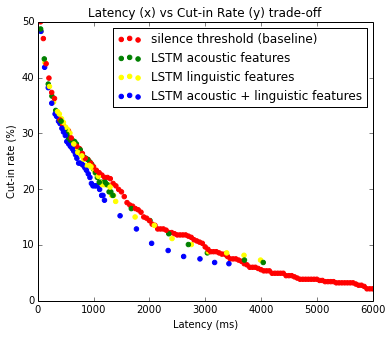

In [4]:
f = [l for l in open("Results/results_lstm_5.text")] 

systems = {}
trade_off = defaultdict(list) #for the baseline, acousticlm,lm,acoustic for averaging
current = []
sys = ""
#f = f.split("\n")
best_trade_off = 1.0
best_system = ""
for line in f:
    if "correct in window" in line: continue
    elif "latency" in line:
        current.insert(0,float(line.split()[0])* 10.0)
            
        if current[0] <= 10000 and ("baseline" in sys and current[0]<6500
                              or "" in sys):
            #if 'baseline' in sys: continue

            test = ((current[0]/10000.0) + (((10000.0 * current[1]))/10000.0))/2
            print (current[0]/10000.0) ,((10000.0 * current[1]))/10000.0, test
            if test < best_trade_off:
            #    best_trade_off = test
            #    best_system = sys
                print "new best",sys, "absolute",current
            

            if not "baseline" in sys and "_" in sys:
                
                parts = sys.split()[1].split("_")
                ratio = float(parts[1])/(float(parts[0])/10)
                #print sys,ratio
                if not (ratio  <=0.31 and ratio>=0.29): #using 0.3
                    #print "out of range",sys
                    sys = ""
                    current = []
                    continue
            sys = sys.replace("_None","")

            systems[sys] = deepcopy(current)
            if "baseline" in sys:
                trade_off["baseline"].append(test)
            elif "acousticlm" in sys:
                trade_off["acoustic_lm"].append(test)
            elif "acoustic" in sys:
                trade_off["acoustic"].append(test)
            elif "lm" in sys:
                trade_off["lm"].append(test)
            else:
                print "sys not in list", sys
            if test < best_trade_off:
                best_trade_off = test
                best_system = sys
                print "new best", best_system, best_trade_off
            
        sys = ""
        current =[]
    elif "cut_ins" in line:
        current.insert(0,float(line.split()[0]))
    elif "Mode" in line:
        sys = " ".join(line.split()[1:])
#print systems
#We want our blue lines to be as far underneath the red ones as we can:
#i.e. for the same cut-off rate, we get much higher accuracy

fig = plt.figure(figsize=(6,5))
plt.xlim(0,6000)
plt.ylim(0.0, 50.0)
plt.title("Latency (x) vs Cut-in Rate (y) trade-off")
plt.ylabel("Cut-in rate (%)")
plt.xlabel("Latency (ms)")
#plt.legend(loc="upper left", bbox_to_anchor=[0, 1], fancybox=True)
print best_trade_off
print best_system, systems[best_system]
red_patch = mpatches.Patch(color='red', label='The red data')
plt.legend(handles=[red_patch])
legendEntries = []
legendText = []

              
for system in systems.keys():
    
    plot = True
    if 'baseline' in system.lower(): 
        col= "red"
        plot = True
        label = "silence threshold (baseline)"
    elif "acousticlm" in system.lower():
        col = "blue"
        plot = True
        label = "LSTM acoustic + linguistic features"
    elif "lm" in system.lower():
        col = "yellow"
        plot = True
        label = "LSTM linguistic features"
    elif 'acoustic' in system.lower():
        col = "green"
        plot = True
        label = "LSTM acoustic features"
    if plot:
        x = systems[system][0] 
        y = systems[system][1] * 100
        #if x<200: 
        #    print system, x,y
        thisPlot = plt.scatter(x,y,color=col,label=label)
        if not label in legendText:    
            legendEntries.append(thisPlot) # only do this for the plots you want 
            #to add to the legend 
            legendText.append(label)    # only this for the plots you want 

plt.legend(legendEntries,legendText,loc='upper right') # example of how to draw the legend 
# fig.savefig("../../Paper/Interspeech/submission/trade-off_4.pdf")
plt.show()
#
#- Plot all folds
#- In a feedback loop there would be interactive feedback. So the speaker would adapt.

In [5]:
def trade_off_results(trade_off):
    for k,v, in sorted(trade_off.items(),key=lambda x:np.average(x[1])):
        print k,np.average(v) ,np.std(v),len(v)
    print "\nsigs over baseline"
    print ttest_ind(trade_off['acoustic_lm'],trade_off['baseline'])
    print ttest_ind(trade_off['lm'],trade_off['baseline']) 
    print ttest_ind(trade_off['acoustic'],trade_off['baseline'])
    print "^"
    print ttest_ind(trade_off['acoustic_lm'],trade_off['acoustic'])
    print ttest_ind(trade_off['acoustic_lm'],trade_off['lm'])
    print ttest_ind(trade_off['lm'],trade_off['acoustic'])
trade_off_results(trade_off)

acoustic_lm 0.16968620495 0.0190883488969 43
lm 0.179186213514 0.0205890909503 43
acoustic 0.180248906973 0.0198622460215 43
baseline 0.216503934192 0.0437179883249 120

sigs over baseline
Ttest_indResult(statistic=-6.7523395808596725, pvalue=2.5089855110048976e-10)
Ttest_indResult(statistic=-5.354286625034387, pvalue=2.9185959036396557e-07)
Ttest_indResult(statistic=-5.2151458358074683, pvalue=5.5764263847981912e-07)
^
Ttest_indResult(statistic=-2.4849340720178517, pvalue=0.014941701573809009)
Ttest_indResult(statistic=-2.1928532275410926, pvalue=0.031082754661428503)
Ttest_indResult(statistic=-0.24073801348183482, pvalue=0.81034477684543349)
